# Phoneme Analysis with Context

Analysis of phonemes with extended context window.

**Analyzing:**
- Phoneme duplicates (same phonemes from the same utterance)
- Missing data
- Distribution by audio file lengths

Uses data from `phoneme_wav_with_context` (created in 01.6).


In [ ]:
from pathlib import Path
import pandas as pd
import librosa
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json

# Determine project root (parent of notebooks directory)
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()

# Paths
PHONEME_TBL = PROJECT_ROOT / 'artifacts' / 'phoneme_intervals.csv'
PHONEME_AUDIO = PROJECT_ROOT / 'artifacts' / 'phoneme_wav_with_context'

pd.options.display.max_rows = 50
pd.options.display.max_columns = None

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## Load Data


In [ ]:
# Load phoneme intervals
print(f"Loading {PHONEME_TBL}...")
df_intervals = pd.read_csv(PHONEME_TBL)
print(f"Loaded {len(df_intervals):,} phoneme intervals")

# Verify phoneme column
if 'phoneme' in df_intervals.columns:
    phoneme_col = 'phoneme'
elif 'mapped_phoneme' in df_intervals.columns:
    phoneme_col = 'mapped_phoneme'
    df_intervals['phoneme'] = df_intervals['mapped_phoneme']
else:
    raise ValueError("Neither 'phoneme' nor 'mapped_phoneme' column found")

print(f"\nUnique phonemes: {df_intervals['phoneme'].nunique()}")
print(f"Unique utterances: {df_intervals['utterance_id'].nunique()}")

# Calculate duration if not present
if 'duration_ms' not in df_intervals.columns:
    df_intervals['duration_ms'] = df_intervals['end_ms'] - df_intervals['start_ms']

display(df_intervals.head())


Loading /Volumes/SSanDisk/SpeechRec-German/artifacts/phoneme_intervals.csv...
Loaded 1,337,749 phoneme intervals

Unique phonemes: 53
Unique utterances: 37139


,utterance_id,phoneme,start_ms,end_ms,duration_ms
0,4aeeae88-0777-2c8c-5c93-2e844a462e49---4783573...,d,0.0,30.0,30.0
1,4aeeae88-0777-2c8c-5c93-2e844a462e49---4783573...,iː,30.0,200.0,170.0
2,4aeeae88-0777-2c8c-5c93-2e844a462e49---4783573...,h,200.0,210.0,10.0
3,4aeeae88-0777-2c8c-5c93-2e844a462e49---4783573...,øː,210.0,460.0,250.0
4,4aeeae88-0777-2c8c-5c93-2e844a462e49---4783573...,ə,460.0,600.0,140.0


In [ ]:
# Load information about created audio files
print(f"Scanning {PHONEME_AUDIO}...")
audio_files = list(PHONEME_AUDIO.glob("*.wav"))
print(f"Found {len(audio_files):,} audio files")

# Parse filenames to extract information
# Format: {utt_id}__{phoneme}__{start_ms}-{end_ms}.wav
audio_data = []
for audio_file in tqdm(audio_files, desc="Parsing filenames"):
    parts = audio_file.stem.split('__')
    if len(parts) >= 3:
        utt_id = parts[0]
        phoneme = parts[1]
        boundary_str = parts[2]
        if '-' in boundary_str:
            orig_start, orig_end = map(int, boundary_str.split('-'))
            audio_data.append({
                'utterance_id': utt_id,
                'phoneme': phoneme,
                'start_ms': orig_start,
                'end_ms': orig_end,
                'file_path': str(audio_file),
                'filename': audio_file.name
            })

df_audio = pd.DataFrame(audio_data)
print(f"\nParsed {len(df_audio):,} audio file records")

display(df_audio.head())


Scanning /Volumes/SSanDisk/SpeechRec-German/artifacts/phoneme_wav_with_context...
Found 1,337,749 audio files


Parsing filenames: 100%|██████████| 1337749/1337749 [00:02<00:00, 480650.17it/s]



Parsed 1,337,749 audio file records


,utterance_id,phoneme,start_ms,end_ms,file_path,filename
0,4aeeae88-0777-2c8c-5c93-2e844a462e49---f710837...,l,4100,4190,/Volumes/SSanDisk/SpeechRec-German/artifacts/p...,4aeeae88-0777-2c8c-5c93-2e844a462e49---f710837...
1,dd01c488-10f3-a683-00cf-4d215f4d9b19---25440f4...,ʁ,1640,1690,/Volumes/SSanDisk/SpeechRec-German/artifacts/p...,dd01c488-10f3-a683-00cf-4d215f4d9b19---25440f4...
2,4aeeae88-0777-2c8c-5c93-2e844a462e49---de5cfab...,z,500,620,/Volumes/SSanDisk/SpeechRec-German/artifacts/p...,4aeeae88-0777-2c8c-5c93-2e844a462e49---de5cfab...
3,dd01c488-10f3-a683-00cf-4d215f4d9b19---9d4b962...,aː,2360,2430,/Volumes/SSanDisk/SpeechRec-German/artifacts/p...,dd01c488-10f3-a683-00cf-4d215f4d9b19---9d4b962...
4,4aeeae88-0777-2c8c-5c93-2e844a462e49---7ea325f...,m,940,1040,/Volumes/SSanDisk/SpeechRec-German/artifacts/p...,4aeeae88-0777-2c8c-5c93-2e844a462e49---7ea325f...


## Duplicate Phoneme Analysis


In [ ]:
# Find duplicates: same phonemes from the same utterance with same boundaries
print("Searching for duplicate phonemes...")

# Group by utterance_id, phoneme, start_ms, end_ms
duplicate_key = ['utterance_id', 'phoneme', 'start_ms', 'end_ms']
duplicates = df_audio[df_audio.duplicated(subset=duplicate_key, keep=False)]

if len(duplicates) > 0:
    print(f"\n⚠️  Found {len(duplicates):,} records with duplicates")
    duplicate_groups = duplicates.groupby(duplicate_key)
    print(f"Unique duplicate combinations: {len(duplicate_groups)}")
    
    # Show examples of duplicates
    print("\nDuplicate examples:")
    for i, ((utt_id, phoneme, start_ms, end_ms), group) in enumerate(duplicate_groups):
        if i >= 5:
            break
        print(f"\n  Utterance: {utt_id}, Phoneme: {phoneme}, Boundaries: {start_ms}-{end_ms}ms")
        print(f"  Files: {len(group)}")
        for idx, row in group.iterrows():
            print(f"    - {row['filename']}")
else:
    print("✅ No duplicates found")

# Also check duplicates by utterance_id and phoneme only (different boundaries, but same phoneme)
print("\n" + "="*60)
print("Check: same phonemes in one utterance (different boundaries)...")
phoneme_duplicates = df_audio.groupby(['utterance_id', 'phoneme']).size()
phoneme_duplicates = phoneme_duplicates[phoneme_duplicates > 1].sort_values(ascending=False)

if len(phoneme_duplicates) > 0:
    print(f"Found {len(phoneme_duplicates):,} cases where one phoneme appears multiple times in utterance")
    print(f"\nTop-10 cases:")
    print(phoneme_duplicates.head(10))
else:
    print("✅ Each phoneme appears only once in each utterance")


Searching for duplicate phonemes...
✅ No duplicates found

Check: same phonemes in one utterance (different boundaries)...
Found 319,735 cases where one phoneme appears multiple times in utterance

Top-10 cases:
utterance_id                                                             phoneme
4aeeae88-0777-2c8c-5c93-2e844a462e49---01c0903fd85db071ce9a8ec0aa58486a  n          24
4aeeae88-0777-2c8c-5c93-2e844a462e49---d2ef9196846148b5ac9afb52f53b94a2  n          23
4aeeae88-0777-2c8c-5c93-2e844a462e49---8510f9f150bca6c043c456a3aa701aa5  n          23
4aeeae88-0777-2c8c-5c93-2e844a462e49---8a1ad05e6488807800defe7328b39134  n          22
4aeeae88-0777-2c8c-5c93-2e844a462e49---79fd34698f43893f7b6716fd4b6478a8  n          21
4aeeae88-0777-2c8c-5c93-2e844a462e49---10e1f82055ea72bb45284e6bf63142e5  n          21
4aeeae88-0777-2c8c-5c93-2e844a462e49---6457b661abf7a5e19a964390bbf7a333  n          20
4aeeae88-0777-2c8c-5c93-2e844a462e49---c0484afb837c53f9c5cd4df7047e6bdf  n          20
4aeeae88-07

## Missing Data Analysis


In [ ]:
# Compare original intervals with created audio files
print("Checking for missing data...")

# Create key for comparison
df_intervals['key'] = (
    df_intervals['utterance_id'].astype(str) + '__' +
    df_intervals['phoneme'].astype(str) + '__' +
    df_intervals['start_ms'].astype(int).astype(str) + '-' +
    df_intervals['end_ms'].astype(int).astype(str)
)

df_audio['key'] = (
    df_audio['utterance_id'].astype(str) + '__' +
    df_audio['phoneme'].astype(str) + '__' +
    df_audio['start_ms'].astype(int).astype(str) + '-' +
    df_audio['end_ms'].astype(int).astype(str)
)

# Find intervals without corresponding audio files
missing_audio = df_intervals[~df_intervals['key'].isin(df_audio['key'])]

if len(missing_audio) > 0:
    print(f"⚠️  Found {len(missing_audio):,} missing intervals (no audio files)")
    print(f"Missing percentage: {len(missing_audio) / len(df_intervals) * 100:.2f}%")
    
    # Show examples
    print("\nExamples of missing intervals:")
    display(missing_audio.head(10))
    
    # Statistics by phoneme
    print("\nTop-10 phonemes with missing data:")
    print(missing_audio['phoneme'].value_counts().head(10))
else:
    print("✅ No missing data found - all intervals have corresponding audio files")

# Find audio files without corresponding intervals (extra files)
extra_audio = df_audio[~df_audio['key'].isin(df_intervals['key'])]

if len(extra_audio) > 0:
    print(f"\n⚠️  Found {len(extra_audio):,} extra audio files (not in original intervals)")
    print("Examples:")
    display(extra_audio.head(10))
else:
    print("\n✅ No extra audio files found")


Checking for missing data...
✅ No missing data found - all intervals have corresponding audio files

✅ No extra audio files found


## Length Distribution Analysis


In [ ]:
# Load audio file durations
print("Loading audio file durations...")

def get_audio_duration(file_path):
    """Get audio file duration in milliseconds."""
    try:
        audio, sr = librosa.load(file_path, sr=None, mono=True)
        duration_ms = len(audio) / sr * 1000
        return duration_ms
    except Exception as e:
        return None

# Load durations (can be limited for quick testing)
SAMPLE_SIZE = None  # None for all files, or a number to limit
files_to_process = df_audio['file_path'].tolist()
if SAMPLE_SIZE:
    files_to_process = files_to_process[:SAMPLE_SIZE]
    print(f"⚠️  Limited to {SAMPLE_SIZE:,} files for testing")

durations = []
for file_path in tqdm(files_to_process, desc="Loading durations"):
    duration = get_audio_duration(file_path)
    durations.append(duration)

# Add durations to DataFrame
df_audio_subset = df_audio.iloc[:len(durations)].copy()
df_audio_subset['audio_duration_ms'] = durations

# Remove None values
df_audio_subset = df_audio_subset[df_audio_subset['audio_duration_ms'].notna()]

print(f"\nLoaded {len(df_audio_subset):,} durations")
print("\nAudio file duration statistics (with context):")
print(df_audio_subset['audio_duration_ms'].describe())

# Compare with original durations (without context)
df_audio_subset['original_duration_ms'] = df_audio_subset['end_ms'] - df_audio_subset['start_ms']
df_audio_subset['context_added_ms'] = df_audio_subset['audio_duration_ms'] - df_audio_subset['original_duration_ms']

print("\nAdded context statistics:")
print(df_audio_subset['context_added_ms'].describe())

display(df_audio_subset.head())


Loading audio file durations...


Loading durations: 100%|██████████| 1337749/1337749 [12:53<00:00, 1730.41it/s]



Loaded 1,337,749 durations

Audio file duration statistics (with context):
count    1.337749e+06
mean     2.840189e+02
std      7.808901e+01
min      5.000000e+01
25%      2.500000e+02
50%      2.700000e+02
75%      3.100000e+02
max      2.788000e+03
Name: audio_duration_ms, dtype: float64

Added context statistics:
count    1.337749e+06
mean     1.961861e+02
std      1.729573e+01
min      0.000000e+00
25%      2.000000e+02
50%      2.000000e+02
75%      2.000000e+02
max      2.010000e+02
Name: context_added_ms, dtype: float64


,utterance_id,phoneme,start_ms,end_ms,file_path,filename,key,audio_duration_ms,original_duration_ms,context_added_ms
0,4aeeae88-0777-2c8c-5c93-2e844a462e49---f710837...,l,4100,4190,/Volumes/SSanDisk/SpeechRec-German/artifacts/p...,4aeeae88-0777-2c8c-5c93-2e844a462e49---f710837...,4aeeae88-0777-2c8c-5c93-2e844a462e49---f710837...,290.0,90,200.0
1,dd01c488-10f3-a683-00cf-4d215f4d9b19---25440f4...,ʁ,1640,1690,/Volumes/SSanDisk/SpeechRec-German/artifacts/p...,dd01c488-10f3-a683-00cf-4d215f4d9b19---25440f4...,dd01c488-10f3-a683-00cf-4d215f4d9b19---25440f4...,250.0,50,200.0
2,4aeeae88-0777-2c8c-5c93-2e844a462e49---de5cfab...,z,500,620,/Volumes/SSanDisk/SpeechRec-German/artifacts/p...,4aeeae88-0777-2c8c-5c93-2e844a462e49---de5cfab...,4aeeae88-0777-2c8c-5c93-2e844a462e49---de5cfab...,320.0,120,200.0
3,dd01c488-10f3-a683-00cf-4d215f4d9b19---9d4b962...,aː,2360,2430,/Volumes/SSanDisk/SpeechRec-German/artifacts/p...,dd01c488-10f3-a683-00cf-4d215f4d9b19---9d4b962...,dd01c488-10f3-a683-00cf-4d215f4d9b19---9d4b962...,270.0,70,200.0
4,4aeeae88-0777-2c8c-5c93-2e844a462e49---7ea325f...,m,940,1040,/Volumes/SSanDisk/SpeechRec-German/artifacts/p...,4aeeae88-0777-2c8c-5c93-2e844a462e49---7ea325f...,4aeeae88-0777-2c8c-5c93-2e844a462e49---7ea325f...,300.0,100,200.0


/var/folders/hg/7_xt468j3nz1xqspwcc6s8jw0000gn/T/ipykernel_5246/1646078921.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([df_top[df_top['phoneme'] == p]['audio_duration_ms'].values


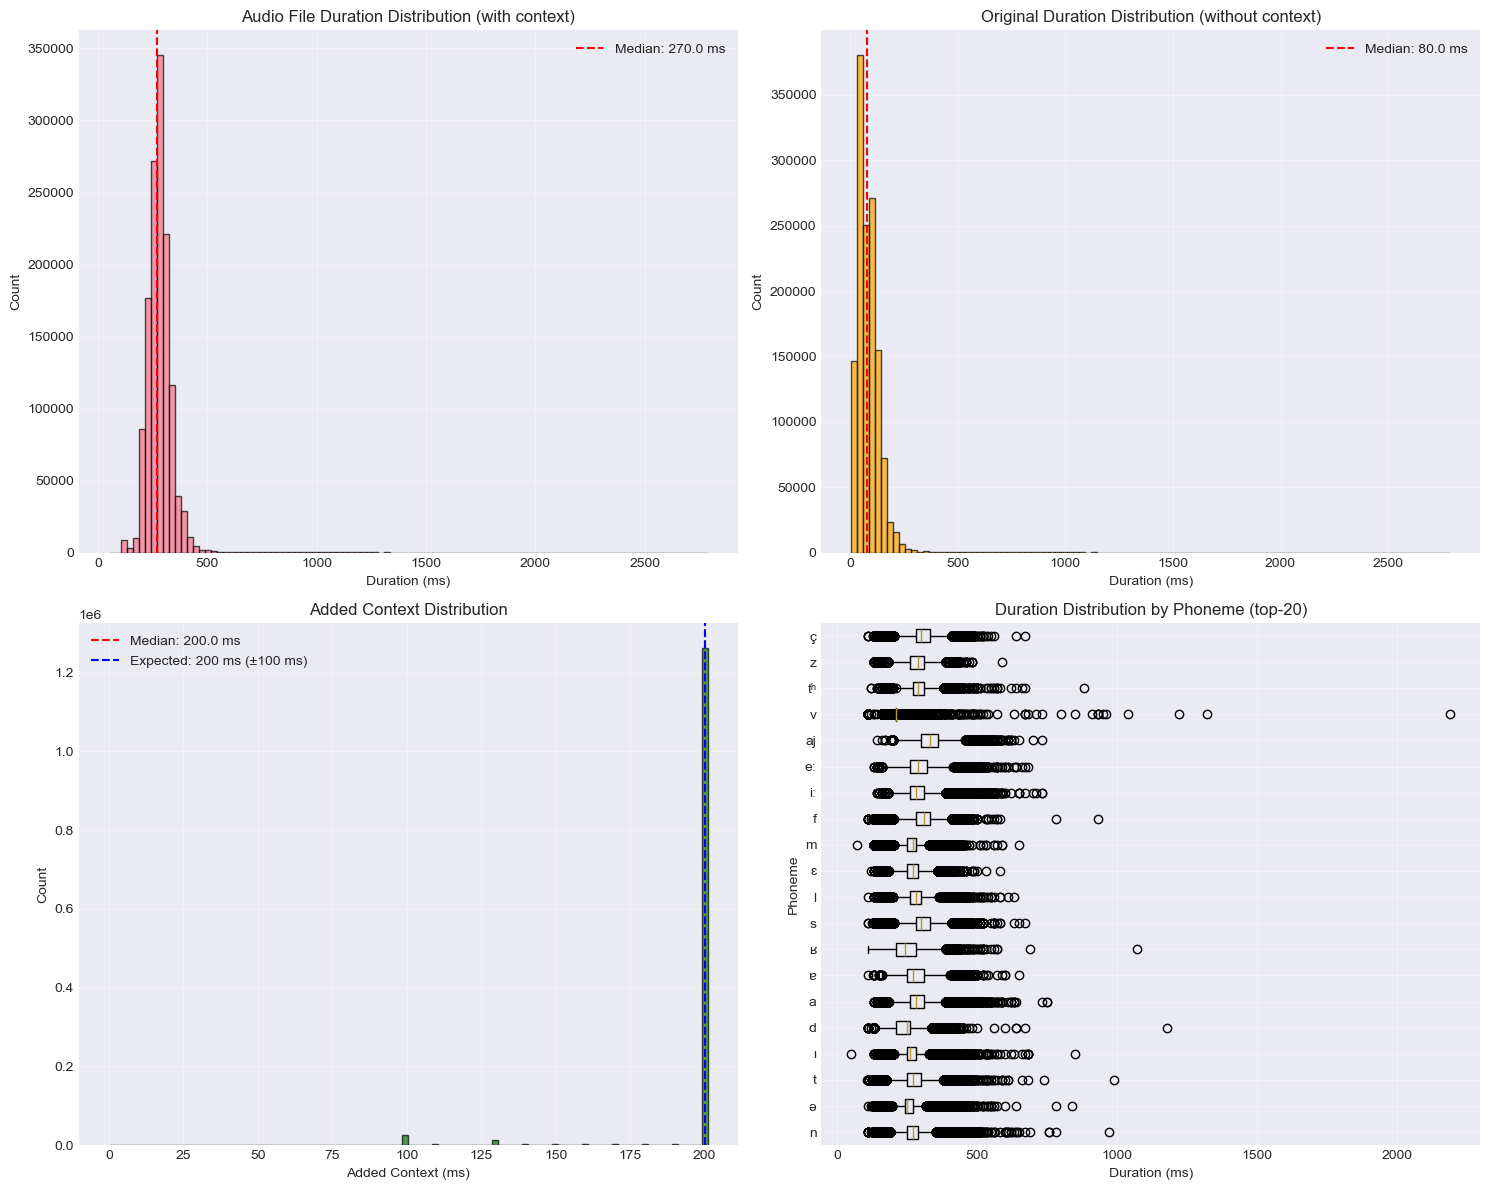

In [ ]:
# Length distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Audio file duration distribution (with context)
axes[0, 0].hist(df_audio_subset['audio_duration_ms'], bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Duration (ms)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Audio File Duration Distribution (with context)')
axes[0, 0].axvline(df_audio_subset['audio_duration_ms'].median(), color='r', linestyle='--', 
                    label=f'Median: {df_audio_subset["audio_duration_ms"].median():.1f} ms')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Original duration distribution (without context)
axes[0, 1].hist(df_audio_subset['original_duration_ms'], bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Duration (ms)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Original Duration Distribution (without context)')
axes[0, 1].axvline(df_audio_subset['original_duration_ms'].median(), color='r', linestyle='--',
                    label=f'Median: {df_audio_subset["original_duration_ms"].median():.1f} ms')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Added context distribution
axes[1, 0].hist(df_audio_subset['context_added_ms'], bins=100, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('Added Context (ms)')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Added Context Distribution')
axes[1, 0].axvline(df_audio_subset['context_added_ms'].median(), color='r', linestyle='--',
                    label=f'Median: {df_audio_subset["context_added_ms"].median():.1f} ms')
axes[1, 0].axvline(200, color='b', linestyle='--', label='Expected: 200 ms (±100 ms)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Box plot by phonemes (top-20)
top_phonemes = df_audio_subset['phoneme'].value_counts().head(20).index
df_top = df_audio_subset[df_audio_subset['phoneme'].isin(top_phonemes)]
axes[1, 1].boxplot([df_top[df_top['phoneme'] == p]['audio_duration_ms'].values 
                    for p in top_phonemes], 
                   labels=top_phonemes, vert=False)
axes[1, 1].set_xlabel('Duration (ms)')
axes[1, 1].set_ylabel('Phoneme')
axes[1, 1].set_title('Duration Distribution by Phoneme (top-20)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Duration statistics by phoneme (top-20):
          count        mean  median        std    min     max
phoneme                                                      
n        126506  272.333455   270.0  40.609911  110.0   970.0
ə         92825  259.219585   250.0  35.868430  110.0   840.0
t         74454  276.982714   270.0  45.753286  105.0   990.0
ɪ         64786  265.745886   260.0  36.181115   50.0   850.0
d         58538  240.420906   250.0  42.309178  110.0  1180.0
a         53416  286.841920   280.0  44.699594  130.0   750.0
ɐ         51617  284.019005   270.0  44.478877  110.0   650.0
ʁ         50700  248.473945   240.0  42.358259  110.0  1070.0
s         50241  304.729962   300.0  39.345986  108.0   670.0
l         50045  279.007893   280.0  33.174255  110.0   630.0
ɛ         41862  269.561368   270.0  32.307757  120.0   580.0
m         40302  269.801474   270.0  33.861593   70.0   650.0
f         34910  307.270352   310.0  42.780962  110.0   930.0
iː        34113  292.017383  

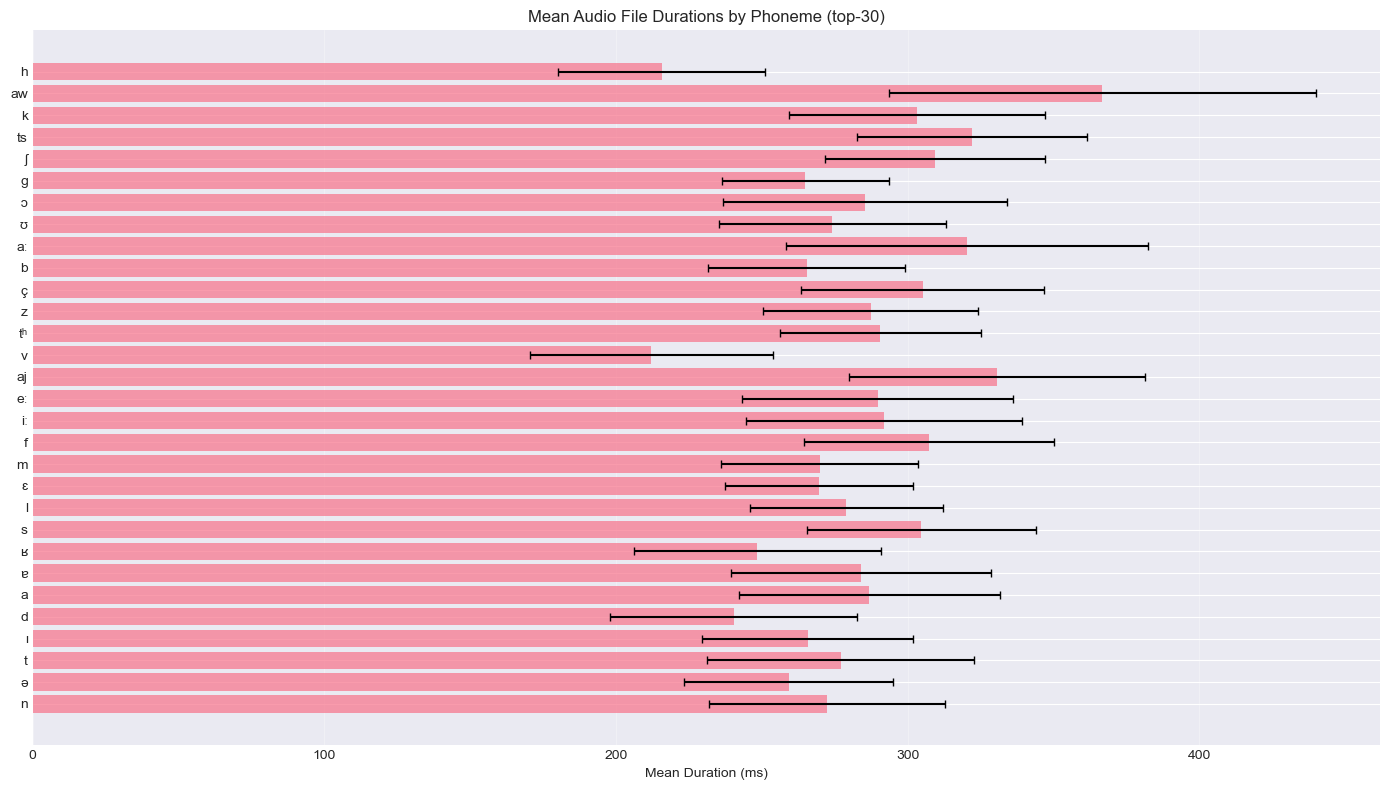

In [ ]:
# Statistics by phoneme
print("Duration statistics by phoneme (top-20):")
phoneme_stats = df_audio_subset.groupby('phoneme')['audio_duration_ms'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).sort_values('count', ascending=False)

print(phoneme_stats.head(20))

# Visualization of mean durations by phoneme
fig, ax = plt.subplots(figsize=(14, 8))
top_30_phonemes = phoneme_stats.head(30)
ax.barh(range(len(top_30_phonemes)), top_30_phonemes['mean'], 
        xerr=top_30_phonemes['std'], capsize=3, alpha=0.7)
ax.set_yticks(range(len(top_30_phonemes)))
ax.set_yticklabels(top_30_phonemes.index)
ax.set_xlabel('Mean Duration (ms)')
ax.set_title('Mean Audio File Durations by Phoneme (top-30)')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


## Additional Analysis: Context Verification


In [ ]:
# Check if context was added correctly
# Expected: ±100 ms = 200 ms of additional context
# But at utterance boundaries, context may be smaller

print("Added context analysis:")
print(f"Expected context: ±100 ms = 200 ms")
print(f"\nActual added context:")
print(f"  Mean: {df_audio_subset['context_added_ms'].mean():.2f} ms")
print(f"  Median: {df_audio_subset['context_added_ms'].median():.2f} ms")
print(f"  Minimum: {df_audio_subset['context_added_ms'].min():.2f} ms")
print(f"  Maximum: {df_audio_subset['context_added_ms'].max():.2f} ms")

# Check how many files have full context (≈200 ms)
full_context = df_audio_subset[
    (df_audio_subset['context_added_ms'] >= 195) & 
    (df_audio_subset['context_added_ms'] <= 205)
]
print(f"\nFiles with full context (195-205 ms): {len(full_context):,} ({len(full_context)/len(df_audio_subset)*100:.1f}%)")

# Files with partial context (at utterance boundaries)
partial_context = df_audio_subset[df_audio_subset['context_added_ms'] < 195]
print(f"Files with partial context (<195 ms): {len(partial_context):,} ({len(partial_context)/len(df_audio_subset)*100:.1f}%)")
print("  (likely at utterance boundaries)")

# Show examples of files with partial context
if len(partial_context) > 0:
    print("\nExamples of files with partial context:")
    display(partial_context[['utterance_id', 'phoneme', 'start_ms', 'end_ms', 
                             'original_duration_ms', 'audio_duration_ms', 'context_added_ms']].head(10))


Added context analysis:
Expected context: ±100 ms = 200 ms

Actual added context:
  Mean: 196.19 ms
  Median: 200.00 ms
  Minimum: 0.00 ms
  Maximum: 201.00 ms



Files with full context (195-205 ms): 1,263,674 (94.5%)
Files with partial context (<195 ms): 74,075 (5.5%)
  (likely at utterance boundaries)

Examples of files with partial context:


,utterance_id,phoneme,start_ms,end_ms,original_duration_ms,audio_duration_ms,context_added_ms
35,4aeeae88-0777-2c8c-5c93-2e844a462e49---c25d486...,s,11350,11410,60,160.0,100.0
42,4aeeae88-0777-2c8c-5c93-2e844a462e49---3399234...,ə,4660,4720,60,248.0,188.0
58,4aeeae88-0777-2c8c-5c93-2e844a462e49---e7e5a75...,pʰ,0,70,70,170.0,100.0
71,4aeeae88-0777-2c8c-5c93-2e844a462e49---c454111...,v,0,10,10,110.0,100.0
79,4aeeae88-0777-2c8c-5c93-2e844a462e49---f5a32bc...,t,2740,2770,30,198.0,168.0
80,4aeeae88-0777-2c8c-5c93-2e844a462e49---1ac42cd...,ɪ,70,140,70,240.0,170.0
96,4aeeae88-0777-2c8c-5c93-2e844a462e49---31d2d6d...,t,4040,4139,99,199.0,100.0
118,4aeeae88-0777-2c8c-5c93-2e844a462e49---c542efd...,n,4860,4950,90,219.0,129.0
121,4aeeae88-0777-2c8c-5c93-2e844a462e49---2f7297b...,v,30,70,40,170.0,130.0
163,4aeeae88-0777-2c8c-5c93-2e844a462e49---a9f78bd...,z,0,110,110,210.0,100.0


## Final Summary


In [ ]:
print("="*60)
print("FINAL SUMMARY OF PHONEME ANALYSIS WITH CONTEXT")
print("="*60)

print(f"\n📊 General Statistics:")
print(f"  Total intervals in source data: {len(df_intervals):,}")
print(f"  Total created audio files: {len(df_audio):,}")
print(f"  Unique phonemes: {df_intervals['phoneme'].nunique()}")
print(f"  Unique utterances: {df_intervals['utterance_id'].nunique()}")

print(f"\n🔍 Duplicate Analysis:")
duplicate_count = len(df_audio[df_audio.duplicated(subset=['utterance_id', 'phoneme', 'start_ms', 'end_ms'], keep=False)])
if duplicate_count > 0:
    print(f"  ⚠️  Found duplicates: {duplicate_count:,}")
else:
    print(f"  ✅ No duplicates found")

print(f"\n❌ Missing Data Analysis:")
missing_count = len(missing_audio) if 'missing_audio' in locals() else 0
if missing_count > 0:
    print(f"  ⚠️  Missing intervals: {missing_count:,} ({missing_count/len(df_intervals)*100:.2f}%)")
else:
    print(f"  ✅ No missing data found")

print(f"\n📏 Duration Analysis:")
if 'df_audio_subset' in locals() and len(df_audio_subset) > 0:
    print(f"  Mean duration (with context): {df_audio_subset['audio_duration_ms'].mean():.2f} ms")
    print(f"  Median duration: {df_audio_subset['audio_duration_ms'].median():.2f} ms")
    print(f"  Mean added context: {df_audio_subset['context_added_ms'].mean():.2f} ms")
    print(f"  Expected context: 200 ms (±100 ms)")

print("\n" + "="*60)


FINAL SUMMARY OF PHONEME ANALYSIS WITH CONTEXT

📊 General Statistics:
  Total intervals in source data: 1,337,749
  Total created audio files: 1,337,749
  Unique phonemes: 53
  Unique utterances: 37139

🔍 Duplicate Analysis:
  ✅ No duplicates found

❌ Missing Data Analysis:
  ✅ No missing data found

📏 Duration Analysis:
  Mean duration (with context): 284.02 ms
  Median duration: 270.00 ms
  Mean added context: 196.19 ms
  Expected context: 200 ms (±100 ms)

